In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# TODO:

- experiments:
    - l(A) i(A...A B A...A)
    - l(AAAB) i(A...A B A...A)
    - l(s(A)) i(s(A)...s(A) B s(A))

- plots:
    - title and axes
    - error per learning step
    - input/stimuli
    - intermediate predictions/reconstructions

- 2xe: if P>I: e_neg=I-P, e_pos=P-I && if P<I: e_neg=I-P, e_pos=P-I
    - cap errors at zero
    
    
    
- different oddball paradigm

In [52]:
SHAPES = {
    'diamond': np.array([[0], [1], [0], [1], [0], [1], [0], [1], [0]]),
    'cross':  np.array([[1], [0], [1], [0], [1], [0], [1], [0], [1]]),
    'plus':  np.array([[0], [1], [0], [1], [1], [1], [0], [1], [0]]),
    'full': np.array([[1], [1], [1], [1], [1], [1], [1], [1], [1]]),
    'square':  np.array([[1], [1], [1], [1], [0], [1], [1], [1], [1]]),
    'point':  np.array([[0], [0], [0], [0], [1], [0], [0], [0], [0]]),
    'vline':  np.array([[0], [1], [0], [0], [1], [0], [0], [1], [0]]),
    'hline':  np.array([[0], [0], [0], [1], [1], [1], [0], [0], [0]]),
    'fslash':  np.array([[0], [0], [1], [0], [1], [0], [1], [0], [0]]),
    'bslash':  np.array([[0], [0], [1], [0], [1], [0], [1], [0], [0]]),
    'unstructured': np.random.rand(9,1)
}

def input_plus_noise(x):
    return x + np.random.normal(loc=0, scale=0.05, size=x.shape)

# simulation parameters
sim_time = 1 #sec
dt = 1e-4
n_iter = 200

In [47]:
class PC_model():
    
    def __init__(self, e_dims, r_dims):
        self.n_layers = len(e_dims)
        self.e = []
        self.r = []
        self.U = []
        for e,r in zip(e_dims, r_dims):
            # Error layers
            self.e.append(np.ones((e, 1)) * 0.1)
            # Prediction/Representation layers
            self.r.append(np.ones((r, 1)) * 0.1)
            # Generative Models
            self.U.append(np.random.normal(loc=0.01, scale=0.005, size=(e, r)))
        # Top-down prior
        self.td_prior = np.random.normal(loc=0.5, scale=0.1, size=(r_dims[-1], 1))
         
    def act(self, x, func):
        if func == 'sigmoid':
            return 1/(1 + np.exp(-x))
        elif func == 'relu':
            return x*(x > 0)
        else:
            return x
    
    def reconstruct(self, l):
        # Reconstruct bottom-up input at layer l
        return self.act(self.U[l] @ self.r[l], 'sigmoid')
    
    def error(self, x):
        # Compute error between stimulus and first layer prediction
        self.e[0] = x - self.reconstruct(0)
        # Compute errors between bottom-up representation and current layer prediction 
        for l in range(1, self.n_layers):
            self.e[l] = self.r[l-1] - self.reconstruct(l)
    
    def infer(self, x):
        # Compute all prediciton errors
        self.error(x)
        for l in range(0, self.n_layers-1):
            self.r[l] = self.r[l-1] + self.act(self.U[l].T @ self.e[l], 'sigmoid')
        self.r[-1] = self.td_prior + self.act(self.U[-1].T @ self.e[-1], 'sigmoid')

    
    def learn(self, lr=1e-3):
        for l in range(0, self.n_layers):
            dU = np.einsum('ik,jk->ij', self.e[l], self.r[l])
            self.U[l] += lr * dU
    
    def SSE(self, l):
        # Sum of squared errors at the layer l
        return np.sum(np.square(self.e[l]))
    
    def memory_loss(self):
        # Degradation of synaptic weights
        for l in range(0, self.n_layers):
            self.U[l] += np.random.normal(loc=0, scale=0.005, size=self.U[l].shape)
    
    def simulate(self, learning_steps, inference_steps, stimuli, learning=True):
        errors = []
        for i in range(learning_steps):
            # Inference
            for t in range(inference_steps):
                self.infer(stimuli[i%len(stimuli)])
            #Learning
            if learning:
                self.learn()
                self.memory_loss()
            errors.append(pc.SSE(0))
                
            if (i + 1) % 20 == 0:
                print (f'Iteration #{i + 1} is simulated, error: {errors[i]}')
        return errors, self.reconstruct(0)
    
    def visualize(self, standard, deviant, recon, errors):
        fig = plt.figure(figsize=(10,6), constrained_layout=True)
        gs = fig.add_gridspec(3,3)
        fig_ax1 = fig.add_subplot(gs[0, 0])
        fig_ax1.imshow(standard.reshape(3,3), vmin=0, vmax=1, cmap='Reds')
        fig_ax1.axis('off')
        fig_ax1.set_title('Standard Stimulus')
        fig_ax2 = fig.add_subplot(gs[0, 1])
        fig_ax2.imshow(deviant.reshape(3,3), vmin=0, vmax=1, cmap='Reds')
        fig_ax2.axis('off')
        fig_ax2.set_title('Deviant Stimulus')
        fig_ax3 = fig.add_subplot(gs[0, 2])
        fig_ax3.imshow(recon.reshape(3,3), vmin=0, vmax=1, cmap='Reds')
        fig_ax3.axis('off')
        fig_ax3.set_title('Reconstruction')
        fig_ax4 = fig.add_subplot(gs[1, :])
        fig_ax4.plot(errors)
        fig_ax4.set_title('Omission Experiment')
        fig_ax4.set_xlabel('# iteration')
        fig_ax4.set_ylabel('Error (SSE)')
        plt.show()

# simulation parameters
inference_steps = 1000
learning_steps = 50

# sA = input_plus_noise(SHAPES['diamond'])

# # predictive coding model
# # form of the input: PC_model([a, b, c], [b, c, d]) 
# pc = PC_model([9], [100])
# errors, recon = pc.simulate(learning_steps, inference_steps, [sA])
# pc.visualize(sA, recon, errors)

Iteration #20 is simulated, error: 1.070223967771548
Iteration #40 is simulated, error: 0.44517401993031963


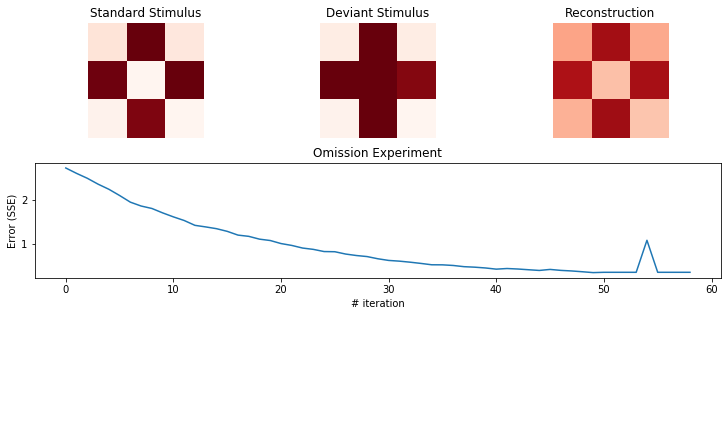

In [53]:
# Repetition

sA = input_plus_noise(SHAPES['diamond'])
sB = input_plus_noise(SHAPES['plus'])

# predictive coding model
pc = PC_model([9], [100])
errors1, _ = pc.simulate(learning_steps, inference_steps, [sA], learning=True)
errors2, recon = pc.simulate(9, inference_steps, [sA, sA, sA, sA, sB], learning=False)
pc.visualize(sA, sB, recon, errors1+errors2)

Iteration #20 is simulated, error: 1.129036981873477
Iteration #40 is simulated, error: 0.533505495987823


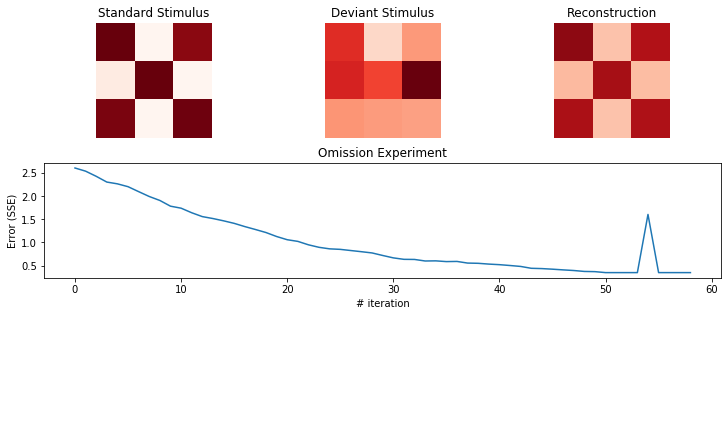

In [50]:
# Omission (structure omission)

sA = input_plus_noise(SHAPES['cross'])
sB = input_plus_noise(SHAPES['unstructured'])

# predictive coding model
pc = PC_model([9], [100])
errors1, _ = pc.simulate(learning_steps, inference_steps, [sA], learning=True)
errors2, recon = pc.simulate(9, inference_steps, [sA, sA, sA, sA, sB], learning=False)
pc.visualize(sA, sB, recon, errors1+errors2)

Iteration #20 is simulated, error: 0.37745867536820343
Iteration #40 is simulated, error: 0.21828664976316686


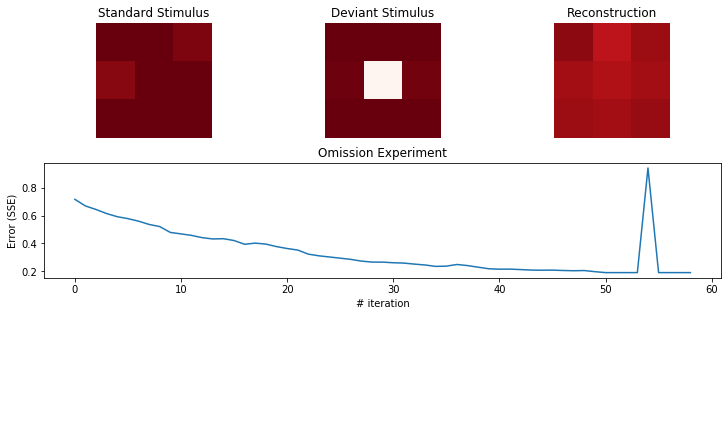

In [49]:
# Omission (pixel omission)

sA = input_plus_noise(SHAPES['full'])
sB = input_plus_noise(SHAPES['square'])

# predictive coding model
pc = PC_model([9], [100])
errors1, _ = pc.simulate(learning_steps, inference_steps, [sA], learning=True)
errors2, recon = pc.simulate(9, inference_steps, [sA, sA, sA, sA, sB], learning=False)
pc.visualize(sA, sB, recon, errors1+errors2)

# negative errors below, but not working

Iteration #20 is simulated, error: 0.0, 0.4754262330063257
Iteration #40 is simulated, error: 0.0, 0.47539300446608324
Iteration #60 is simulated, error: 0.0, 0.47533954431248543
Iteration #80 is simulated, error: 0.0, 0.4752531381817302
Iteration #100 is simulated, error: 0.0, 0.475113076518083


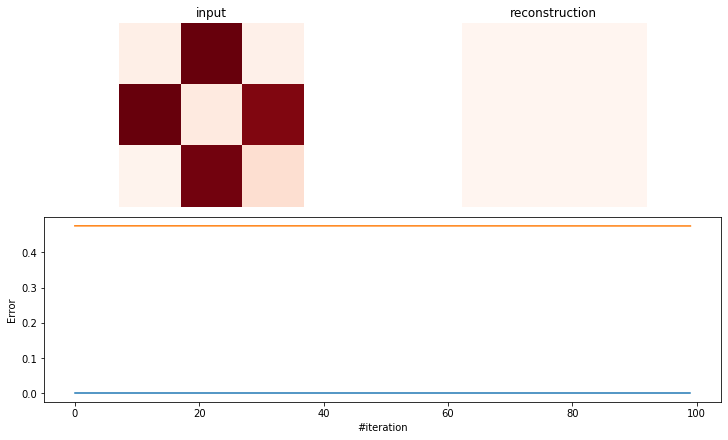

In [8]:
class PC_model():
    
    def __init__(self, e_dims, r_dims):
        self.n_layers = len(e_dims)
        self.e_pos = []
        self.e_neg = []
        self.r = []
        self.U = []
        for e,r in zip(e_dims, r_dims):
            # Error layers
            self.e_neg.append(np.ones((e, 1)) * 0.1)
            self.e_pos.append(np.ones((e, 1)) * -0.1)
            # Prediction/Representation layers
            self.r.append(np.ones((r, 1)) * 0.1)
            # Generative Models
            self.U.append(np.random.normal(loc=0.01, scale=0.005, size=(e, r)))
        # Top-down prior
        self.td_prior = np.random.normal(loc=0.5, scale=0.1, size=(r_dims[-1], 1))
         
    def act(self, x, func):
        if func == 'sigmoid':
            return 1/(1 + np.exp(-x+10))
        elif func == 'relu':
            return x*(x > 0)
        else:
            return x
    
    def reconstruct(self, l):
        # Reconstruct bottom-up input at layer l
        return self.act(self.U[l] @ self.r[l], 'sigmoid')
    
    def error(self, x):
        # Compute error between stimulus and first layer prediction
        r = self.reconstruct(0)
        self.e_pos[0] = self.act(r - x, 'relu')
        self.e_neg[0] = self.act(x - r, 'relu')
        # Compute errors between bottom-up representation and current layer prediction 
        for l in range(1, self.n_layers):
            r = self.reconstruct(l)
            self.e_pos[l] = self.act(self.r[l-1] - r, 'relu')
            self.e_neg[l] = self.act(r - self.r[l-1], 'relu')
    
    def predict(self, x):
        # Compute all prediciton errors
        self.error(x)
        # Inference
        for l in range(0, self.n_layers-1):
            self.r[l] = self.act(self.U[l].T @ self.e_neg[l], 'sigmoid')
            #            self.act(self.U[l].T @ self.e_pos[l], 'sigmoid')

        self.r[-1] = self.td_prior + self.act(self.U[-1].T @ self.e_neg[-1], 'sigmoid')
        #            self.act(self.U[-1].T @ self.e_pos[-1], 'sigmoid')

    
    def update(self, lr=1e-3):
        # Learning
        for l in range(0, self.n_layers):
            dU = np.einsum('ik,jk->ij', (self.e_neg[l]), self.r[l])
            self.U[l] += lr * dU
            
    def memory_loss(self):
        # Degradation of synaptic weights
        for l in range(0, self.n_layers):
            self.U[l] += np.random.normal(loc=0, scale=0.1, size=self.U[l].shape)
    
    #def SSE(self):
    #    # Sum of squared errors at all layers
    #    SSEs = []
    #    for l in range(0, len(self.e)):
    #        SSEs.append(np.sum(np.square(self.e[l])))
    #    return SSEs
    
    def SSE(self, l):
        # Sum of squared errors at the layer l
        #return np.sum(np.square(self.e[l]))
        return np.mean(self.e_pos[l]), np.mean(self.e_neg[l])
    
    def simulate(self, learning_steps, inference_steps, standard, deviant=None):
        errors_p, errors_n = [], []
        for i in range(learning_steps):
            # Inference
            for t in range(inference_steps):
                self.predict(standard)
            #Learning
            self.update()
            #self.memory_loss()
            ep, en = pc.SSE(0)
            errors_p.append(ep)
            errors_n.append(en)
            if (i + 1) % 20 == 0:
                print (f'Iteration #{i + 1} is simulated, error: {errors_p[i]}, {errors_n[i]}')
        return errors_p, errors_n, self.reconstruct(0)
    
    def visualize(self, standard, recon, errors_p, errors_n):
        fig = plt.figure(figsize=(10,6), constrained_layout=True)
        gs = fig.add_gridspec(2,2)
        fig_ax1 = fig.add_subplot(gs[0, 0])
        fig_ax1.imshow(standard.reshape(3,3), vmin=0, vmax=1, cmap='Reds')
        fig_ax1.axis('off')
        fig_ax1.set_title('input')
        fig_ax2 = fig.add_subplot(gs[0, 1])
        fig_ax2.imshow(recon.reshape(3,3), vmin=0, vmax=1, cmap='Reds')
        fig_ax2.axis('off')
        fig_ax2.set_title('reconstruction')
        fig_ax3 = fig.add_subplot(gs[1, :])
        fig_ax3.plot(errors_p)
        fig_ax3.plot(errors_n)
        fig_ax3.set_xlabel('#iteration')
        fig_ax3.set_ylabel('Error')
        plt.show()


# predictive coding model
# form of the input: PC_model([a, b, c], [b, c, d]) 
pc = PC_model([9], [100])


sA = input_plus_noise(SHAPES['diamond']) #make list and present list[i%len(list)]
#sB = 

# simulation parameters
inference_steps = 10000
learning_steps = 100

errors_p, errors_n, recon = pc.simulate(learning_steps, inference_steps, sA)
pc.visualize(sA, recon, errors_p, errors_n)